In [1]:
#@title Importing Packages

# Utility
import math as math
import numpy as np
import pandas as pd
import random as rdm
import scipy.io as io
import scipy.stats as stats
from google.colab import drive
import networkx as nx

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.animation import FuncAnimation
from functools import partial

# Binomial

In [6]:
def findMode(sample):

    mode = 0
    count = 0
    for value in set(sample):
        countValue = sum([1 for num in sample if num == value])
        if countValue >= count:
            mode = value
            count = countValue
    
    return mode, count


In [2]:
#@title Function to plot pdf of distribution

def plotPDF(dist, mean, true):

    sample = dist.rvs(10000)
    plt.hist(sample, bins = int(len(sample)/100))

    maxValue = findMode(sample)[1]
    plt.plot([mean, mean], [0, maxValue], label = 'Mean')
    plt.plot([true, true], [0, maxValue], label = 'True value')

    plt.legend()
    plt.show()



In [3]:
#@title function to plot walk of single parameter

def plotWalk(sample, true):

    plt.plot(range(len(sample)), sample)
    plt.plot([0, len(sample)], [true, true], label = 'True value')
    plt.legend()
    plt.show()

The true value of p is 0.856


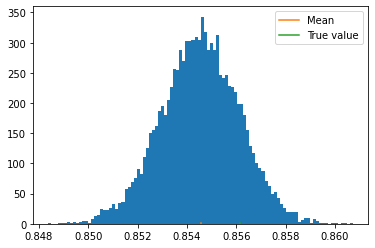

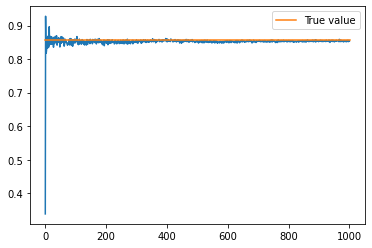

In [7]:
#@title Gibbs sampler for binomial distribution
pTrue = stats.uniform.rvs()

likelihood = stats.binom(1, pTrue)

a = 1
b = 1
prior = stats.beta(a, b)
pSample = [prior.rvs()]

for i in range(1000):

    sample = likelihood.rvs(rdm.randint(0, 100))

    n = len(sample)
    y = sum(sample)

    a = a + y
    b = b + n - y

    mean = a/(a + b)
    posterior = stats.beta(a, b)
    pSample.append(posterior.rvs())

print(f"The true value of p is {format(pTrue, '.3f')}")
plotPDF(posterior, mean, pTrue)
plotWalk(pSample, pTrue)

X: 0.8846691717106306 0.1479999619313056
P1:  0.9999999999999996 0.19892573549918746
P2:  0.9999999999999996 0.1808810480807067

X: 0.1479999619313056 -0.8563941292504661
P1:  0.0 0.1819975457581758
P2:  0.9999999999999996 0.19892573549918746

X: 0.1479999619313056 1.2219887011006487
P1:  0.0 0.16550683896510085
P2:  0.9999999999999996 0.19892573549918746

X: 0.1479999619313056 -0.23236515623859894
P1:  0.0 0.1981294033486754
P2:  0.9999999999999996 0.19892573549918746

X: 0.1479999619313056 1.455362725218932
P1:  0.0 0.15307216585928435
P2:  0.9999999999999996 0.19892573549918746

X: 0.1479999619313056 0.26581235372952927
P1:  0.9999999999999998 0.19771716290727834
P2:  0.9999999999999996 0.19892573549918746

X: 0.26581235372952927 -0.24872200610323603
P1:  0.0 0.19793461238582638
P2:  0.9999999999999998 0.19771716290727834

X: 0.26581235372952927 -0.5754912438326827
P1:  0.0 0.19138187809778212
P2:  0.9999999999999998 0.19771716290727834

X: 0.26581235372952927 -2.2463129882585773
P1

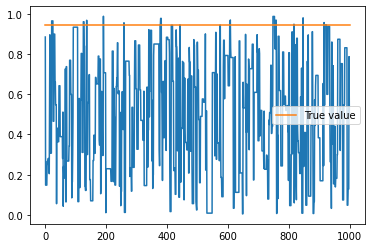

In [8]:
#@title Metropolis-Hastings for binomial - Not working
pTrue = stats.uniform.rvs()

likelihood = stats.binom(1, pTrue)

a = 1
b = 1
prior = stats.beta(a, b)
pSample = [prior.rvs()]

xNaught = stats.uniform(0, 1).rvs()
posterior = np.zeros((1000,))

for t in range(1000):
    posterior[t] = xNaught

    x = stats.norm(loc = xNaught).rvs() # candidate
    print("X:", xNaught, x)
    p1 = stats.beta.pdf(x, a, b) * stats.norm.pdf(x, 0, 2) # prior * likelihood 
    print("P1: ", stats.beta.pdf(x, a, b), stats.norm.pdf(x, 0, 2))
    p2 = stats.beta.pdf(xNaught, a, b) * stats.norm.pdf(xNaught, 0, 2) # prior * likelihood 
    print("P2: ", stats.beta.pdf(xNaught, a, b), stats.norm.pdf(xNaught, 0, 2))
    print("")
    alpha = p1/p2 # ratio
    u = stats.uniform(0, 1).rvs() # random uniform

    if u < alpha:
        xNaught = x # accept

plotWalk(posterior, pTrue)

# Normal

In [15]:
def variance(sample):

    mean = np.mean(sample)
    var = sum([value - mean for value in sample])**2/(len(y) - 1)

    return var

In [16]:
#@title Gibbs Sampler for normal distribution - Mu working, Sigma squared not

# Initial sample
y = [1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08]
n = len(y) 
ybar = np.mean(y)
s2 = variance(y)

print(ybar, s2)

# Prior
mu0 = 1.9
kappa0 = 1
t20 = (mu0/stats.norm.ppf(0.975))
s20 = 0.01
nu0 = 1

print(mu0, s20)
# Initialising array
S = 10000
phi = [ybar, s2]
PHI = np.zeros((S, 2))
PHI[0, :] = phi

rdm.seed(1)
for s in range(1, S):

    mun = (mu0/t20 + n*ybar/phi[1])/(1/t20 + n/phi[1])
    t2n = 1/(1/t20 + n/phi[1])

    phi[0] = stats.norm(mun, np.sqrt(t2n)).rvs(1)

    # Sample sigmaˆ2 from its full conditional based on theta

    nun = nu0 + n
    kappan = kappa0 + n
    s2n = (nu0*s20 + (n - 1)*s2 + n*(ybar - phi[0])**2)/nun

    # This posterior distribution: inverse-gamma(nu_n/2,sigmaˆ2_n(\theta)
    phi[1] = stats.invgamma(nun/2, s2n*nun/2).rvs(1)

    PHI[s, :] = phi


1.8044444444444447 8.874685183736383e-31
1.9 0.01


<ipython-input-16-7d07b7e5755d>:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  PHI[s, :] = phi


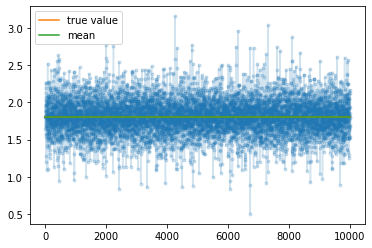

In [17]:
#@title Plotting walk of mean

plt.plot(range(10000), PHI[:, 0], '.-', alpha = 0.2)
plt.plot([0, 10000], [ybar, ybar], label = 'true value')
plt.plot([0, 10000], [np.mean(PHI[:, 0]), np.mean(PHI[:, 0])], label = 'mean')

plt.legend()

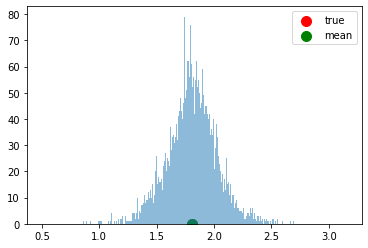

In [18]:
#@title Plotting histogram of mean

plt.hist(PHI[:, 0], bins = 1000, alpha = 0.5)
plt.scatter(ybar, 0, s = 100, c = 'r', label = 'true')
plt.scatter(np.mean(PHI[:, 0]), 0, s = 100, c = 'g', label = 'mean')

plt.legend()

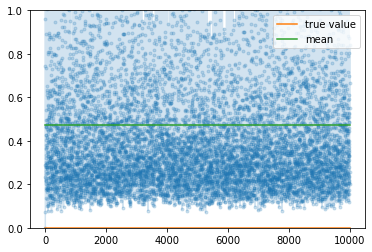

In [19]:
#@title Plotting walk of sigma squared

plt.plot(range(10000), (PHI[:, 1]), '.-', alpha = 0.2)
plt.plot([0, 10000], [s2, s2], label = 'true value')
plt.plot([0, 10000], [np.mean(PHI[:, 1]), np.mean(PHI[:, 1])], label = 'mean')
plt.ylim(0, 1)
plt.legend()

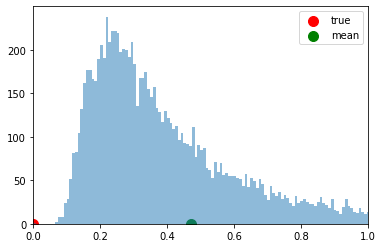

In [20]:
#@title Plotting histogram of sigma squared

plt.hist((PHI[:, 1]), bins = 1000, alpha = 0.5)
plt.scatter(s2, 0, s = 100, c = 'r', label = 'true')
plt.scatter(np.mean((PHI[:, 1])), 0, s = 100, c = 'g', label = 'mean')
plt.xlim(0, 1)
plt.legend()

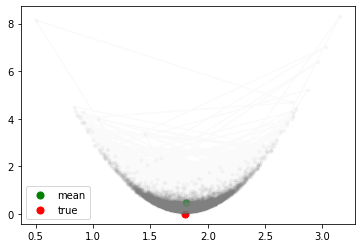

In [21]:
#@title Plotting mean vs sigma-squared

plt.scatter(np.mean(PHI[:, 0]), np.mean(PHI[:, 1]), s = 50, c = 'g', label = 'mean')
plt.plot(PHI[:, 0], PHI[:, 1], '.-', alpha = 0.04, c = 'grey')
plt.scatter(ybar, s2, s = 50, c = 'r', label = 'true')

plt.legend()